In [145]:
import numpy as np
import matplotlib.pyplot as plt
from parse import parse
import cv2

In [146]:
train_images, train_labels = parse('digitdata/trainingimages', 'digitdata/traininglabels', True)
validation_images, validation_labels = parse('digitdata/validationimages', 'digitdata/validationlabels', True)
test_images, test_labels = parse('digitdata/testimages', 'digitdata/testlabels', True)

In [147]:
base_rate_true = np.bincount(train_labels)/train_labels.shape[0]
print(base_rate_true)

[0.0958 0.1126 0.0976 0.0986 0.107  0.0868 0.1002 0.11   0.0924 0.099 ]


In [148]:
kernel = np.ones((3,3))
images = np.swapaxes(np.swapaxes(train_images.astype(np.float64), 0, 2), 0, 1)
dst = np.zeros_like(images)

if images.shape[2] > 512:
    for i in range(int(np.ceil(images.shape[2]/512))):
        dst[:, :, i*512:(i+1)*512] = cv2.filter2D(src = images[:, :, i*512:(i+1)*512], ddepth = -1, kernel = kernel, anchor = (0,0))
else:
    dst= cv2.filter2D(src = images, ddepth = -1, kernel = kernel, anchor = (0,0))

zones = dst[::3,::3,:]
print(zones.shape)
    

    

(9, 9, 5000)


In [149]:
def train_perceptron_numbers(passes, labels, zones):
    weights = np.zeros((81,10))
    bias = np.zeros(10)
    for k in range(passes):
        for i in range(len(zones[0][0])):            
            b, index = 0, 0
            arr = zones[:,:,i].ravel()
            for j in range(len(weights[0])):
                a = np.dot(weights[:,j],arr) + bias[j]
                if a > b:
                    b = a
                    index = j
            if labels[i] != index:
                weights[:,index] -= arr
                bias[index] -= 1
                weights[:, labels[i]] += arr
                bias[labels[i]] += 1
    return weights, bias

   

In [151]:
vimages = np.swapaxes(np.swapaxes(validation_images.astype(np.float64), 0, 2), 0, 1)
vdst = np.zeros_like(vimages)

if vimages.shape[2] > 512:
    for i in range(int(np.ceil(vimages.shape[2]/512))):
        vdst[:, :, i*512:(i+1)*512] = cv2.filter2D(src = vimages[:, :, i*512:(i+1)*512], ddepth = -1, kernel = kernel, anchor = (0,0))
else:
    vdst= cv2.filter2D(src = vimages, ddepth = -1, kernel = kernel, anchor = (0,0))

vzones = vdst[::3,::3,:]

timages = np.swapaxes(np.swapaxes(test_images.astype(np.float64), 0, 2), 0, 1)
tdst = np.zeros_like(timages)

if timages.shape[2] > 512:
    for i in range(int(np.ceil(timages.shape[2]/512))):
        tdst[:, :, i*512:(i+1)*512] = cv2.filter2D(src = timages[:, :, i*512:(i+1)*512], ddepth = -1, kernel = kernel, anchor = (0,0))
else:
    tdst= cv2.filter2D(src = timages, ddepth = -1, kernel = kernel, anchor = (0,0))

tzones = tdst[::3,::3,:]
print(tzones.shape)


(9, 9, 1000)


In [152]:
def run_perceptron_numbers(weights, labels, zones, bias):
    tally = 0
    for i in range(len(zones[0][0])):
        b, index = 0, 0
        arr = zones[:,:,i].ravel()
        for j in range(len(weights[0])):
            a = np.dot(weights[:,j],arr) + bias[j]
            if a > b:
                b = a
                index = j
        if labels[i] == index:
            tally += 1

    return(tally/len(zones[0][0]))


In [153]:
w, b = train_perceptron_numbers(100, train_labels, zones)

run_perceptron_numbers(w, validation_labels, vzones, b)

run_perceptron_numbers(w, test_labels, tzones, b)

0.842

In [166]:
def run_percentage(zones, labels, tzones, tlabels):
    accuracy = np.zeros(10, dtype=np.float64)
    for i in range(1,11):
        amount = int(0.1 * i * len(zones[0][0]))
        available_indices = np.random.choice(len(zones[0][0]), amount, replace = False)
        available_zones = zones[:,:,available_indices]
        available_labels= labels[available_indices]
        w, b = train_perceptron_numbers(100, available_labels, available_zones)
        
        accuracy[i-1] = run_perceptron_numbers(w, tlabels, tzones, b)
    return accuracy

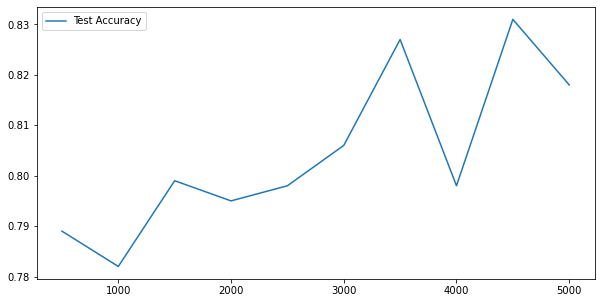

In [167]:
x = np.linspace(.1*train_images.shape[0], train_images.shape[0], 10)
acc = run_percentage(zones, train_labels, tzones, test_labels)
plt.figure(figsize = (10, 5))
plt.plot(x, acc[:], label = "Test Accuracy")
plt.legend()